# Enhanced Knowledge Graph Embeddings with PyKEEN

## Features:
- Uses Google Colab T4 by default, but has sensible fall-backs
- M3 Mac GPU acceleration (MPS backend)
- Multiple embedding models comparison
- Advanced visualizations (PCA, t-SNE, UMAP)
- Entity similarity and clustering analysis
- Link prediction and evaluation
- Relationship pattern analysis
- Interactive visualizations

## Installation

In [1]:
%%capture
!pip install -q pykeen torch pandas numpy matplotlib seaborn scikit-learn umap-learn plotly ipywidgets
# Enable widgets for Jupyter
!jupyter nbextension enable --py widgetsnbextension --sys-prefix 2>/dev/null || true

## Setup and Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyKEEN imports
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
from pykeen import predict

# Visualization imports
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cosine, euclidean
from scipy.cluster.hierarchy import dendrogram, linkage

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available, install with: pip install umap-learn")

try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Plotly not available for interactive visualizations")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports complete")

INFO:pykeen.utils:Using opt_einsum


✅ Imports complete


In [3]:
import torch
import os

def get_device():
    """Detect and configure optimal device for Colab (CUDA) or Mac (MPS)"""

    # 1. Check for NVIDIA GPU (Google Colab / Linux / Windows)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"🚀 Using NVIDIA GPU ({torch.cuda.get_device_name(0)})")
        # Optional: Print VRAM to ensure you have enough for embeddings
        vram = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"   VRAM Available: {vram:.2f} GB")

    # 2. Check for Apple Silicon (M1/M2/M3 Mac)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🍎 Using Apple Silicon GPU (MPS backend)")

    # 3. Fallback to CPU
    else:
        device = torch.device("cpu")
        print("⚠️  Using CPU (Training will be slow)")

    print(f"PyTorch version: {torch.__version__}")
    return device

# Initialize
device = get_device()

# Configure Threads (Auto-detect based on environment)
# In Colab, os.cpu_count() usually returns 2 (standard) or 8+ (high-RAM)
cpu_cores = os.cpu_count()
torch.set_num_threads(cpu_cores)
print(f"Device set to: {device}")
print(f"CPU threads set to: {torch.get_num_threads()}")

🚀 Using NVIDIA GPU (Tesla T4)
   VRAM Available: 15.83 GB
PyTorch version: 2.9.0+cu126
Device set to: cuda
CPU threads set to: 2


## Data Loading and Preparation

triples extracted via https://colab.research.google.com/drive/1W97x1sMo_EUrz2VSu0o9C0LJ3BQrepj2?usp=sharing using claude skill file

In [4]:
# Load edges table
#df = pd.read_csv("original_kg/original-kg.csv")
df = pd.read_csv("triples.csv")
#df = df.drop(columns='attributes', errors='ignore')
#df = df.rename(columns={'source': 'subject', 'target': 'object', 'relation': 'predicate'})

print(f"Loaded {len(df)} triples")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample triples:")
display(df.head())

# Statistics
print(f"\n📊 Dataset Statistics:")
print(f"  Unique entities: {len(set(df['subject'].unique().tolist() + df['object'].unique().tolist()))}")
print(f"  Unique relations: {len(df['predicate'].unique())}")
print(f"  Total triples: {len(df)}")
print(f"\nRelation distribution:")
print(df['predicate'].value_counts())

Loaded 171 triples

Columns: ['subject', 'predicate', 'object']

Sample triples:


,subject,predicate,object
0,giacomo_medici,soldTo,j_paul_getty_museum
1,giacomo_medici,soldTo,j_paul_getty_museum
2,peruvian_artifacts,lootedFrom,peru
3,peruvian_artifacts,handledBy,david_bernstein
4,mexican_antiquities,lootedFrom,mexico



📊 Dataset Statistics:
  Unique entities: 115
  Unique relations: 25
  Total triples: 171

Relation distribution:
predicate
isEntityType          46
hasRole               18
isType                13
isObjectType          11
hasLocationType       10
hasSignificance        9
locatedIn              8
lootedFrom             8
isLocatedIn            7
hasNationality         5
hasLegalStatus         5
originFrom             4
soldTo                 4
handledBy              4
repatriatedTo          4
employedBy             3
recoveredBy            2
hasOrganization        2
hasAge                 2
authenticatedBy        1
hasEstimatedDate       1
hasCondition           1
hasProvenanceNotes     1
currentlyLocatedIn     1
knownInvolvement       1
Name: count, dtype: int64


In [5]:
# Create triples factory
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

# Create train/validation/test split
# For small graphs, we use the same data (in production, use proper split)
training, validation, testing = triples_factory.split([0.7, 0.15, 0.15], random_state=42)

print(f"\n📦 Data Split:")
print(f"  Training: {training.num_triples} triples")
print(f"  Validation: {validation.num_triples} triples")
print(f"  Testing: {testing.num_triples} triples")

# Create lookup dictionaries
id_to_entity = {v: k for k, v in triples_factory.entity_to_id.items()}
id_to_relation = {v: k for k, v in triples_factory.relation_to_id.items()}

print("\n✅ Triples factory created")

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [23, 25, 25]



📦 Data Split:
  Training: 114 triples
  Validation: 25 triples
  Testing: 25 triples

✅ Triples factory created


## Model Training and Comparison

We'll train multiple models to compare performance:
- **TransE**: Translational model (entities + relations in same space)
- **RotatE**: Rotation-based embeddings in complex space
- **ComplEx**: Complex embeddings with Hermitian dot product
- **DistMult**: Bilinear diagonal model
- **ConvE**: Convolutional model

In [6]:
# Configuration for M3 optimization
EMBEDDING_DIM = 64  # Increased for better representation
NUM_EPOCHS = 300
BATCH_SIZE = 256  # Optimized for M3 GPU
LEARNING_RATE = 0.001

# Model configurations
models_config = {
    'TransE': {
        'model': 'TransE',
        'loss': 'softplus',
        'model_kwargs': {'embedding_dim': EMBEDDING_DIM},
        'optimizer_kwargs': {'lr': LEARNING_RATE},
    },
    'RotatE': {
        'model': 'RotatE',
        'model_kwargs': {'embedding_dim': EMBEDDING_DIM},
        'optimizer_kwargs': {'lr': LEARNING_RATE},
    },
    'ComplEx': {
        'model': 'ComplEx',
        'model_kwargs': {'embedding_dim': EMBEDDING_DIM},
        'optimizer_kwargs': {'lr': LEARNING_RATE},
    },
    'DistMult': {
        'model': 'DistMult',
        'model_kwargs': {'embedding_dim': EMBEDDING_DIM},
        'optimizer_kwargs': {'lr': LEARNING_RATE},
    },
}

print(f"\n🎯 Training Configuration:")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Device: {device}")


🎯 Training Configuration:
  Embedding dimension: 64
  Batch size: 256
  Epochs: 300
  Learning rate: 0.001
  Device: cuda


In [7]:
def train_model(model_name, config):
    """Train a model with Colab (CUDA) or M3 (MPS) optimization"""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    # 1. Device Logic
    # Complex number models (RotatE, ComplEx) are fully supported on NVIDIA (CUDA).
    # They historically have issues on Mac (MPS), so we only fallback if on MPS.
    complex_models = {'RotatE', 'ComplEx'}

    # Default to the global device detected in the previous cell
    use_device = str(device)

    # Check: Are we on Mac AND is this a complex model?
    if use_device == 'mps' and model_name in complex_models:
        use_device = 'cpu'
        print(f"⚠️  {model_name} uses complex embeddings - falling back to CPU (MPS limitation)")
    else:
        # For CUDA (Colab) or standard models, confirm we are using the GPU
        if 'cuda' in use_device:
            print(f"🚀 Training on NVIDIA GPU")
        elif 'mps' in use_device:
            print(f"🍎 Training on Apple Silicon (MPS)")

    # 2. Run Pipeline
    result = pipeline(
        training=training,
        validation=validation,
        testing=testing,
        **config,
        training_kwargs={
            'num_epochs': NUM_EPOCHS,
            'batch_size': BATCH_SIZE,
            'use_tqdm_batch': False,
        },
        device=use_device, # <--- UNCOMMENTED AND PASSED CORRECTLY
        random_seed=42,
    )

    print(f"✅ {model_name} training complete")
    return result

# Train all models
results = {}
for model_name, config in models_config.items():
    try:
        results[model_name] = train_model(model_name, config)
    except Exception as e:
        print(f"❌ Error training {model_name}: {e}")
        print(f"   Skipping this model...")
        continue

print("\n" + "="*60)
print(f"Successfully trained {len(results)} models!")
print("="*60)

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()



Training TransE
🚀 Training on NVIDIA GPU


Training epochs on cuda:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.24s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


✅ TransE training complete

Training RotatE
🚀 Training on NVIDIA GPU


Training epochs on cuda:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)


✅ RotatE training complete

Training ComplEx
🚀 Training on NVIDIA GPU


Training epochs on cuda:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.08s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)


✅ ComplEx training complete

Training DistMult
🚀 Training on NVIDIA GPU


Training epochs on cuda:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


✅ DistMult training complete

Successfully trained 4 models!


## Model Evaluation and Comparison

In [8]:
# Evaluate all models
evaluator = RankBasedEvaluator()
metrics_comparison = {}

for model_name, result in results.items():
    print(f"\nEvaluating {model_name}...")

    metrics = evaluator.evaluate(
        result.model,
        testing.mapped_triples,
        additional_filter_triples=[training.mapped_triples, validation.mapped_triples]
    )

    metrics_comparison[model_name] = {
        'Hits@1': metrics.get_metric('hits@1'),
        'Hits@3': metrics.get_metric('hits@3'),
        'Hits@5': metrics.get_metric('hits@5'),
        'Hits@10': metrics.get_metric('hits@10'),
        'MRR': metrics.get_metric('mean_reciprocal_rank'),
    }

    print(f"  Hits@1: {metrics_comparison[model_name]['Hits@1']:.4f}")
    print(f"  Hits@10: {metrics_comparison[model_name]['Hits@10']:.4f}")
    print(f"  MRR: {metrics_comparison[model_name]['MRR']:.4f}")

# Convert to DataFrame for comparison
metrics_df = pd.DataFrame(metrics_comparison).T
print("\n📊 Model Performance Comparison:")
display(metrics_df.style.highlight_max(axis=0, color='lightgreen'))


Evaluating TransE...


Evaluating on cuda:0:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


  Hits@1: 0.0000
  Hits@10: 0.3800
  MRR: 0.0988

Evaluating RotatE...


Evaluating on cuda:0:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


  Hits@1: 0.0400
  Hits@10: 0.1400
  MRR: 0.0819

Evaluating ComplEx...


Evaluating on cuda:0:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


  Hits@1: 0.0000
  Hits@10: 0.0800
  MRR: 0.0298

Evaluating DistMult...


Evaluating on cuda:0:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


  Hits@1: 0.0200
  Hits@10: 0.2000
  MRR: 0.0905

📊 Model Performance Comparison:


,Hits@1,Hits@3,Hits@5,Hits@10,MRR
TransE,0.000000,0.080000,0.160000,0.380000,0.098833
RotatE,0.040000,0.060000,0.100000,0.140000,0.081873
ComplEx,0.000000,0.000000,0.000000,0.080000,0.029835
DistMult,0.020000,0.120000,0.120000,0.200000,0.090519


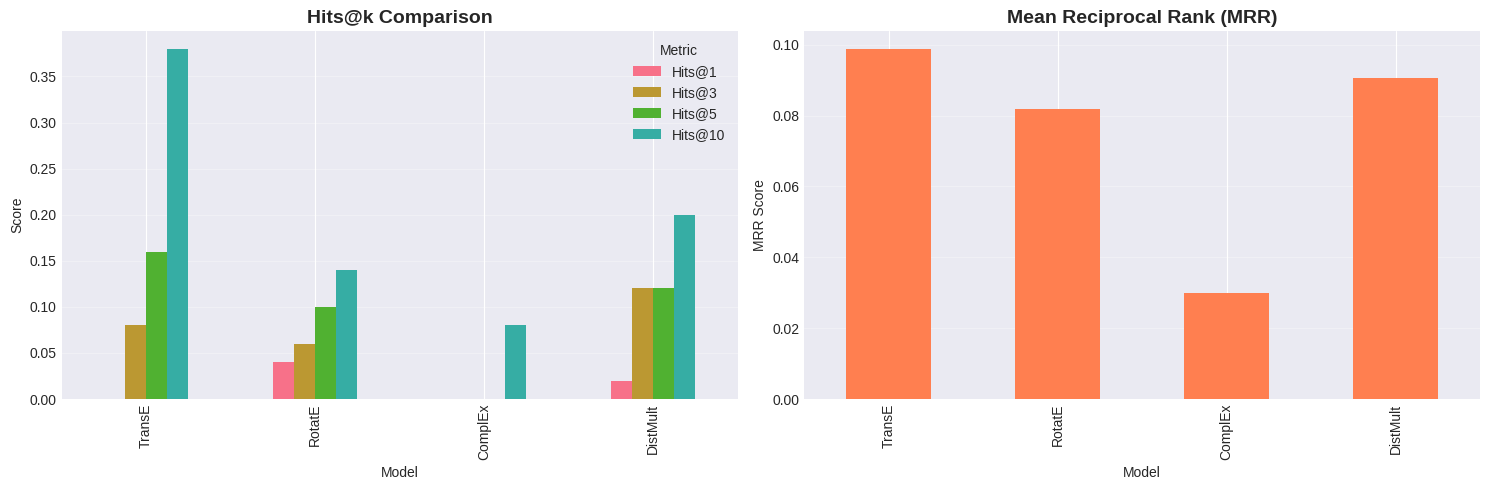


🏆 Best performing model: TransE
   MRR: 0.0988


In [9]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Hits@k comparison
hits_metrics = metrics_df[['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10']]
hits_metrics.plot(kind='bar', ax=axes[0])
axes[0].set_title('Hits@k Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(title='Metric')
axes[0].grid(axis='y', alpha=0.3)

# MRR comparison
metrics_df['MRR'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Mean Reciprocal Rank (MRR)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MRR Score')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best model
best_model_name = metrics_df['MRR'].idxmax()
print(f"\n🏆 Best performing model: {best_model_name}")
print(f"   MRR: {metrics_df.loc[best_model_name, 'MRR']:.4f}")

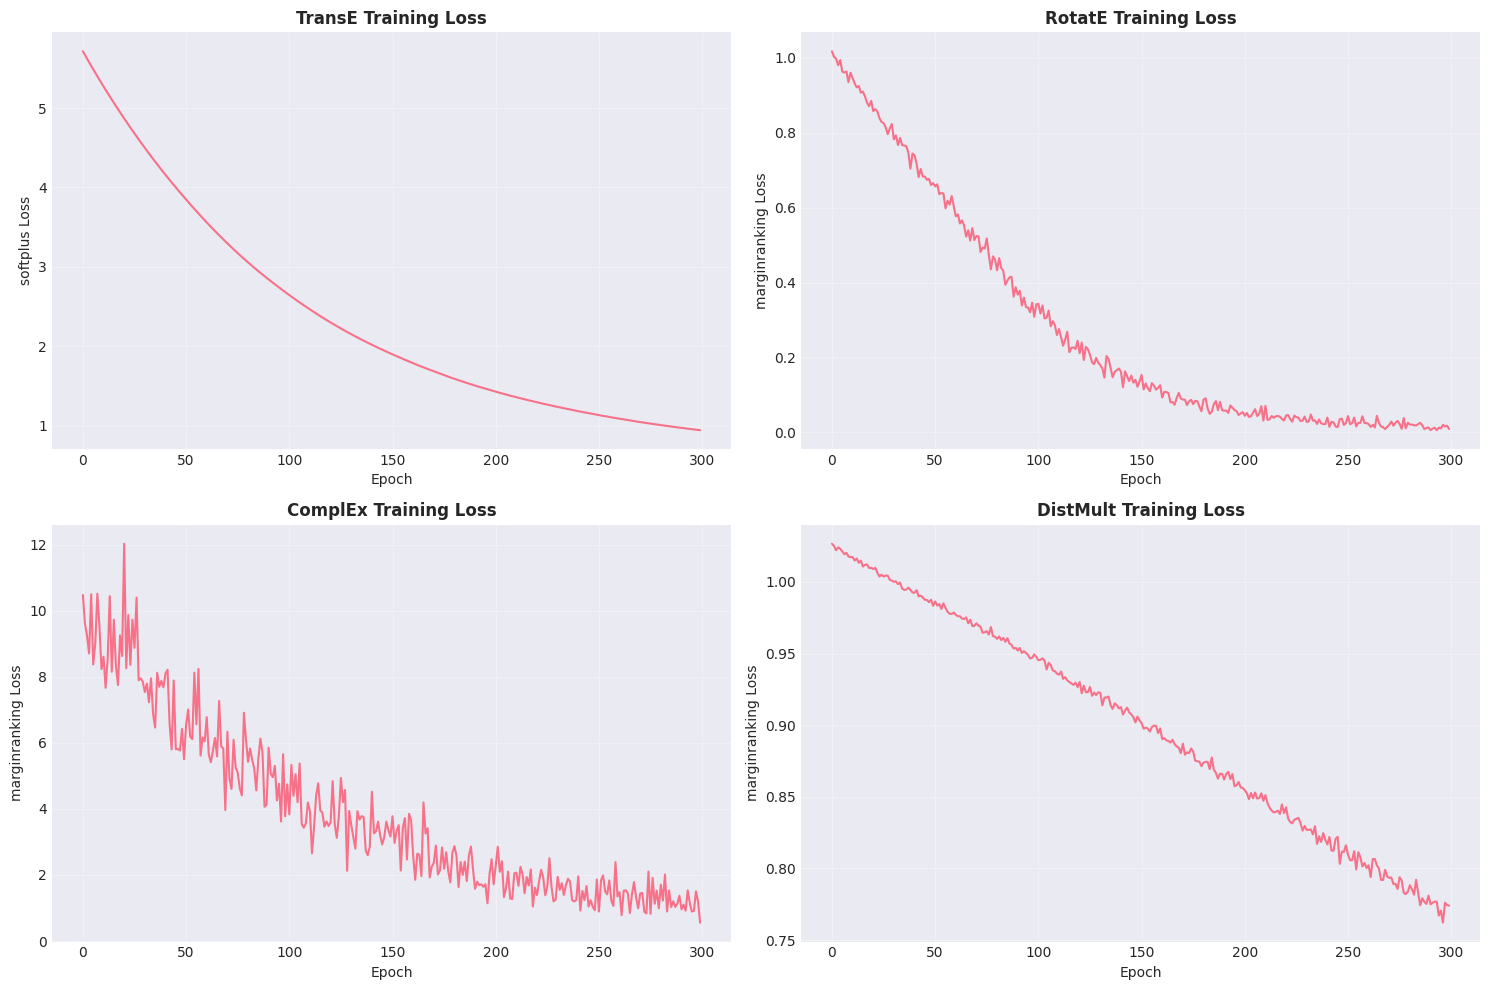

In [10]:
# Plot training losses for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (model_name, result) in enumerate(results.items()):
    if idx < len(axes):
        result.plot_losses(ax=axes[idx])
        axes[idx].set_title(f'{model_name} Training Loss', fontweight='bold')
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_losses.png', dpi=300, bbox_inches='tight')
plt.show()

## Embedding Analysis

Now we'll explore the learned embeddings using the best model.

In [11]:
import torch
# Use best model for detailed analysis
best_model = results[best_model_name].model

# Extract embeddings - handle complex-valued models
entity_embeddings_raw = best_model.entity_representations[0](indices=None).detach().cpu()
relation_embeddings_raw = best_model.relation_representations[0](indices=None).detach().cpu()

# Convert complex to real if necessary
if entity_embeddings_raw.is_complex():
    print(f"Converting complex embeddings to real (using magnitude)...")
    # Use magnitude for complex embeddings (could also use real part or concatenate real+imag)
    entity_embeddings = torch.abs(entity_embeddings_raw).numpy()
    relation_embeddings = torch.abs(relation_embeddings_raw).numpy()
else:
    entity_embeddings = entity_embeddings_raw.numpy()
    relation_embeddings = relation_embeddings_raw.numpy()

print(f"\n📐 Embedding Dimensions:")
print(f"  Entity embeddings: {entity_embeddings.shape}")
print(f"  Relation embeddings: {relation_embeddings.shape}")
print(f"  Using {best_model_name} model for analysis")
print(f"  Embeddings are: {'real-valued' if not entity_embeddings_raw.is_complex() else 'complex (converted to magnitude)'}")


📐 Embedding Dimensions:
  Entity embeddings: (115, 64)
  Relation embeddings: (25, 64)
  Using TransE model for analysis
  Embeddings are: real-valued


### 2D Visualizations: PCA, t-SNE, UMAP

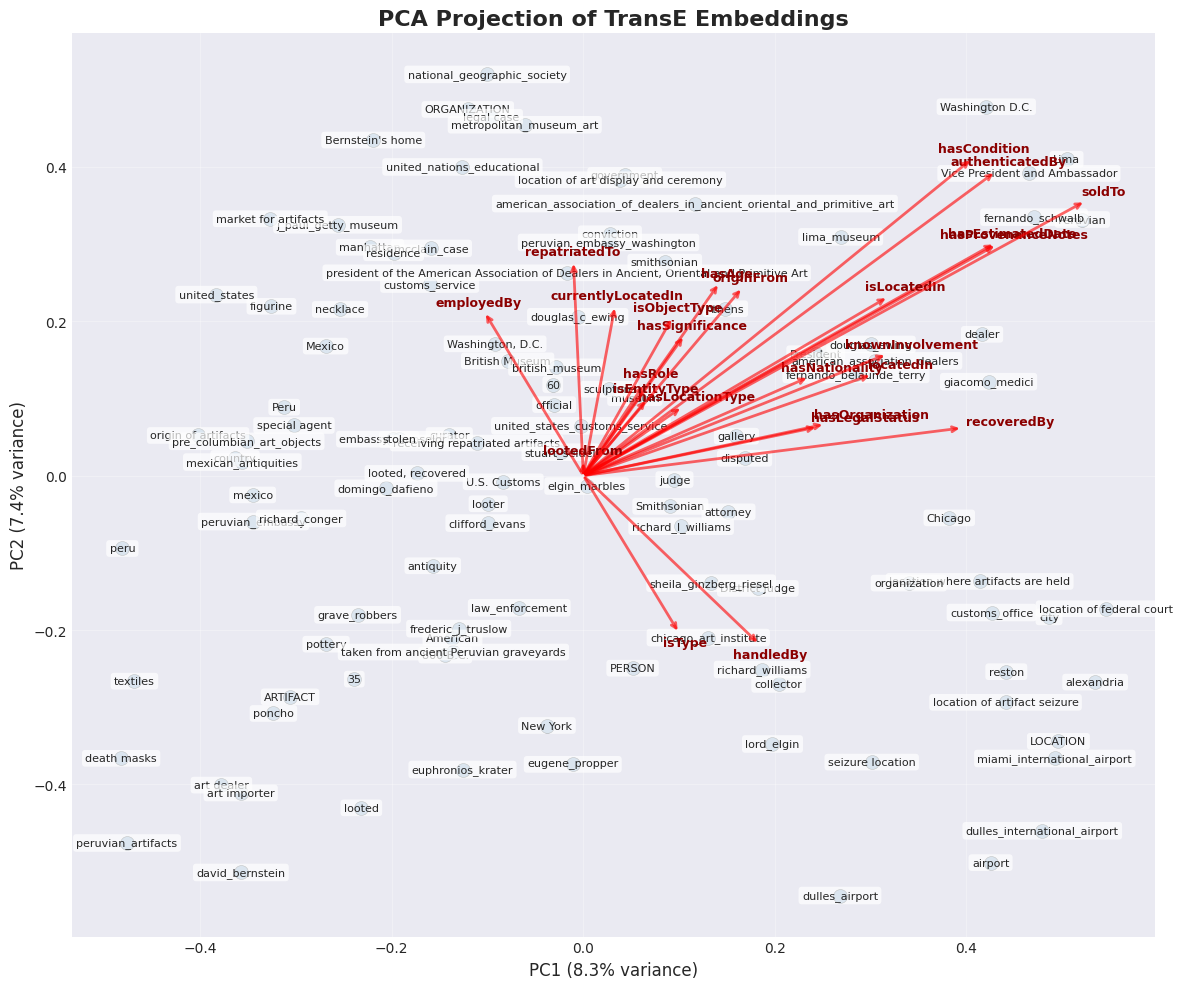


PCA explained variance: 15.8%


In [12]:
# PCA Visualization
pca = PCA(n_components=2, random_state=42)
entity_pca = pca.fit_transform(entity_embeddings)
relation_pca = pca.transform(relation_embeddings)

plt.figure(figsize=(12, 10))

# Plot entities
plt.scatter(entity_pca[:, 0], entity_pca[:, 1], c='steelblue',
           s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

for i, entity_id in enumerate(triples_factory.entity_id_to_label):
    plt.annotate(
        text=id_to_entity[entity_id],
        xy=(entity_pca[i, 0], entity_pca[i, 1]),
        fontsize=8,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

# Plot relations as arrows from origin
for i, relation_id in enumerate(triples_factory.relation_id_to_label):
    plt.annotate(
        text=id_to_relation[relation_id],
        xy=(0, 0),
        xytext=(relation_pca[i, 0], relation_pca[i, 1]),
        arrowprops=dict(
            arrowstyle='<-',
            color='red',
            lw=2,
            alpha=0.6
        ),
        fontsize=9,
        fontweight='bold',
        color='darkred'
    )

plt.title(f'PCA Projection of {best_model_name} Embeddings', fontsize=16, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pca_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")

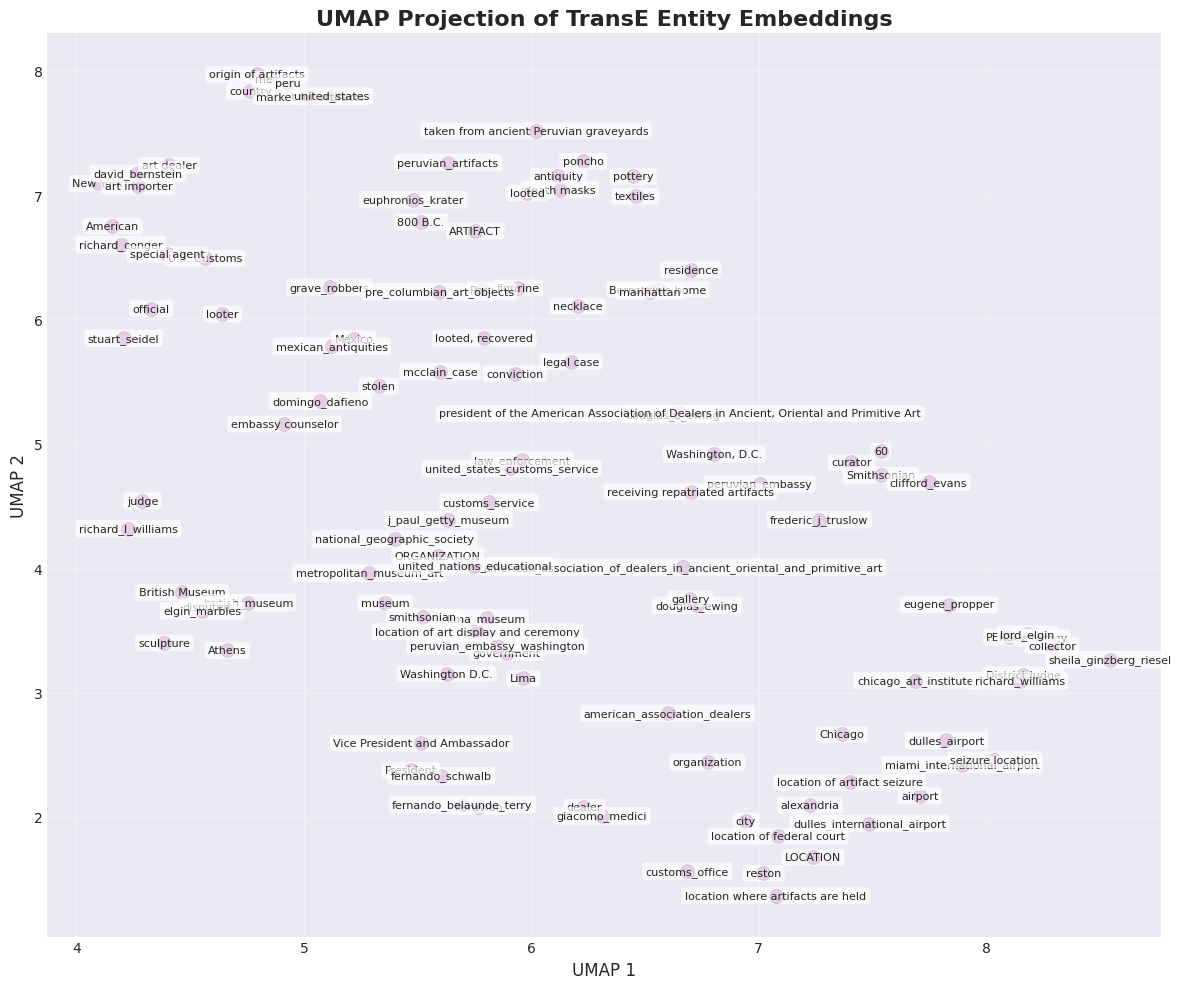

In [13]:
# UMAP Visualization (if available)
if UMAP_AVAILABLE and len(entity_embeddings) >= 15:
    reducer = umap.UMAP(n_components=2, random_state=42)
    entity_umap = reducer.fit_transform(entity_embeddings)

    plt.figure(figsize=(12, 10))
    plt.scatter(entity_umap[:, 0], entity_umap[:, 1], c='purple',
               s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

    for i, entity_id in enumerate(triples_factory.entity_id_to_label):
        plt.annotate(
            text=id_to_entity[entity_id],
            xy=(entity_umap[i, 0], entity_umap[i, 1]),
            fontsize=8,
            ha='center',
            va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
        )

    plt.title(f'UMAP Projection of {best_model_name} Entity Embeddings', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP 1', fontsize=12)
    plt.ylabel('UMAP 2', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('umap_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️  UMAP visualization skipped (not available or insufficient data)")

### Entity Similarity Analysis

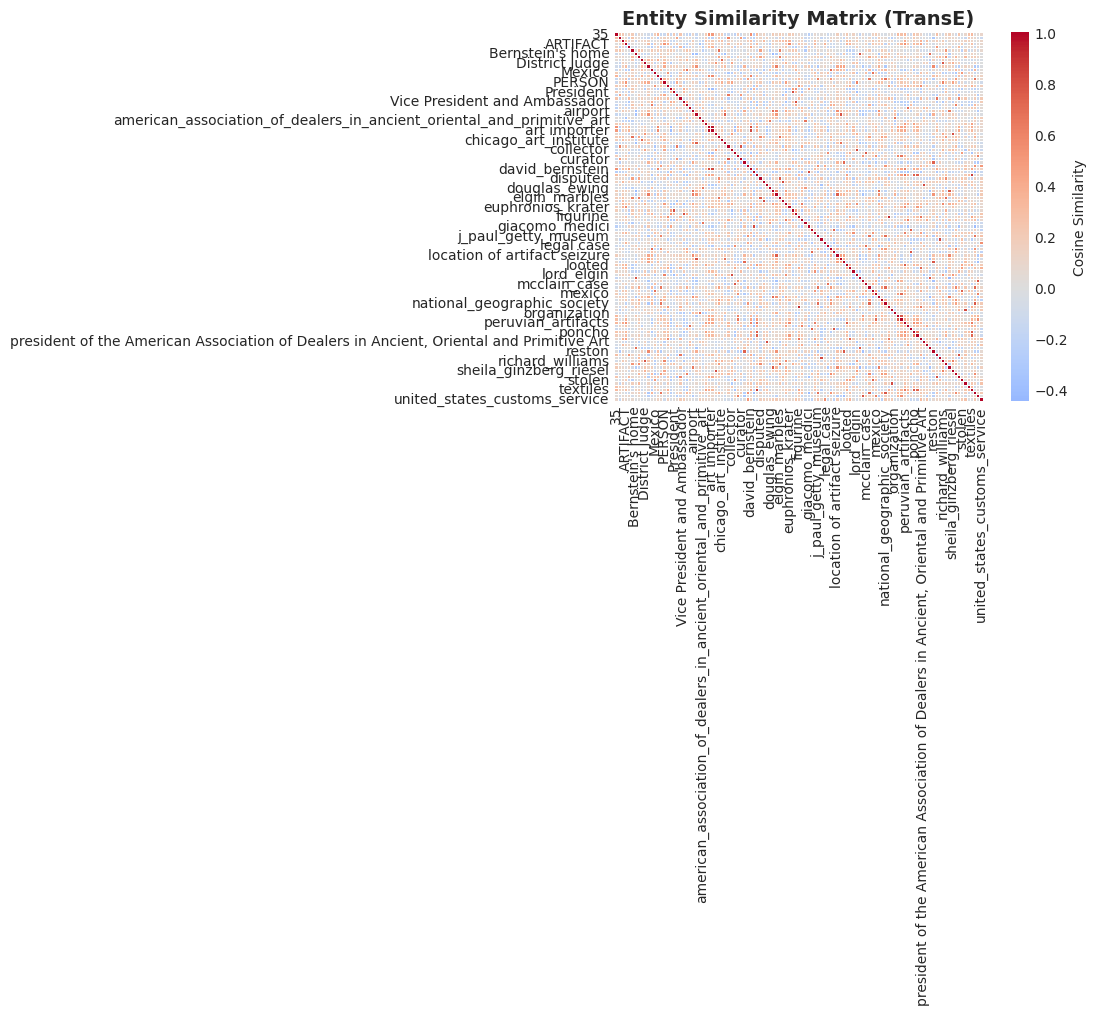


🔍 Most Similar Entity Pairs:
  1. art dealer <-> art importer: 0.9690
  2. figurine <-> necklace: 0.9240
  3. death masks <-> textiles: 0.8779
  4. domingo_dafieno <-> embassy counselor: 0.8374
  5. douglas_c_ewing <-> president of the American Association of Dealers in Ancient, Oriental and Primitive Art: 0.8343
  6. dealer <-> giacomo_medici: 0.8310
  7. official <-> stuart_seidel: 0.8308
  8. judge <-> richard_l_williams: 0.8307
  9. art importer <-> david_bernstein: 0.8296
  10. collector <-> lord_elgin: 0.8239


In [14]:
# Compute pairwise cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(entity_embeddings)

# Create DataFrame with entity labels
entity_labels = [id_to_entity[i] for i in range(len(id_to_entity))]
similarity_df = pd.DataFrame(similarity_matrix, index=entity_labels, columns=entity_labels)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='coolwarm', center=0,
            annot=len(entity_labels) < 15, fmt='.2f',
            square=True, linewidths=0.5, cbar_kws={'label': 'Cosine Similarity'})
plt.title(f'Entity Similarity Matrix ({best_model_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Most Similar Entity Pairs:")
# Find top similar pairs (excluding diagonal)
np.fill_diagonal(similarity_matrix, -1)
top_pairs = []
for i in range(len(entity_labels)):
    for j in range(i+1, len(entity_labels)):
        top_pairs.append((entity_labels[i], entity_labels[j], similarity_matrix[i, j]))

top_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (e1, e2, sim) in enumerate(top_pairs[:10]):
    print(f"  {i+1}. {e1} <-> {e2}: {sim:.4f}")

In [16]:
# Function to find most similar entities
def find_similar_entities(entity_name, top_k=5):
    """Find most similar entities to a given entity"""
    if entity_name not in triples_factory.entity_to_id:
        print(f"Entity '{entity_name}' not found")
        return

    entity_id = triples_factory.entity_to_id[entity_name]
    entity_embedding = entity_embeddings[entity_id]

    # Compute similarities
    similarities = cosine_similarity([entity_embedding], entity_embeddings)[0]

    # Get top-k (excluding self)
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]

    print(f"\n🎯 Top {top_k} entities most similar to '{entity_name}':")
    for i, idx in enumerate(top_indices):
        similar_entity = id_to_entity[idx]
        similarity = similarities[idx]
        print(f"  {i+1}. {similar_entity}: {similarity:.4f}")

    return [(id_to_entity[idx], similarities[idx]) for idx in top_indices]

# Example: Find entities similar to a specific one
# Replace with an actual entity from your graph
if len(entity_labels) > 0:
    example_entity = entity_labels[5]
    find_similar_entities(example_entity)


🎯 Top 5 entities most similar to 'Athens':
  1. british_museum: 0.6825
  2. elgin_marbles: 0.6174
  3. sculpture: 0.5320
  4. disputed: 0.4722
  5. British Museum: 0.3296


### Clustering Analysis

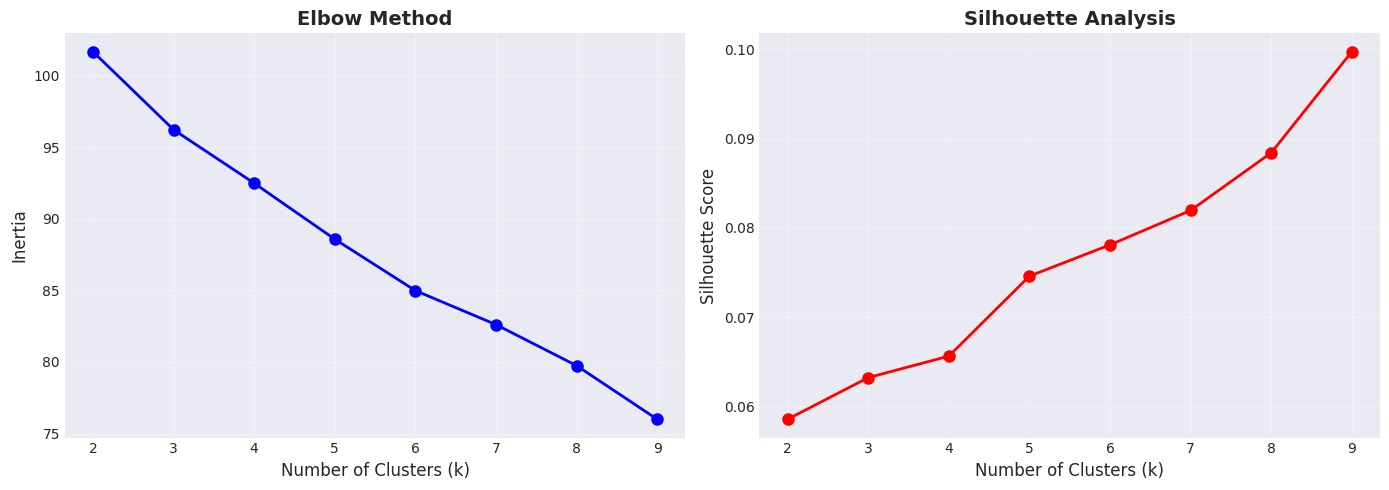


✅ Optimal number of clusters: 9


In [17]:
# K-Means clustering
optimal_k = min(5, len(entity_embeddings) // 2)

# Elbow method to find optimal k
if len(entity_embeddings) >= 10:
    inertias = []
    silhouette_scores = []
    k_range = range(2, min(10, len(entity_embeddings)))

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(entity_embeddings)
        inertias.append(kmeans.inertia_)
        if k < len(entity_embeddings):
            silhouette_scores.append(silhouette_score(entity_embeddings, labels))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Elbow plot
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[0].set_ylabel('Inertia', fontsize=12)
    axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)

    # Silhouette plot
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[1].set_ylabel('Silhouette Score', fontsize=12)
    axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('clustering_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Use k with best silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\n✅ Optimal number of clusters: {optimal_k}")

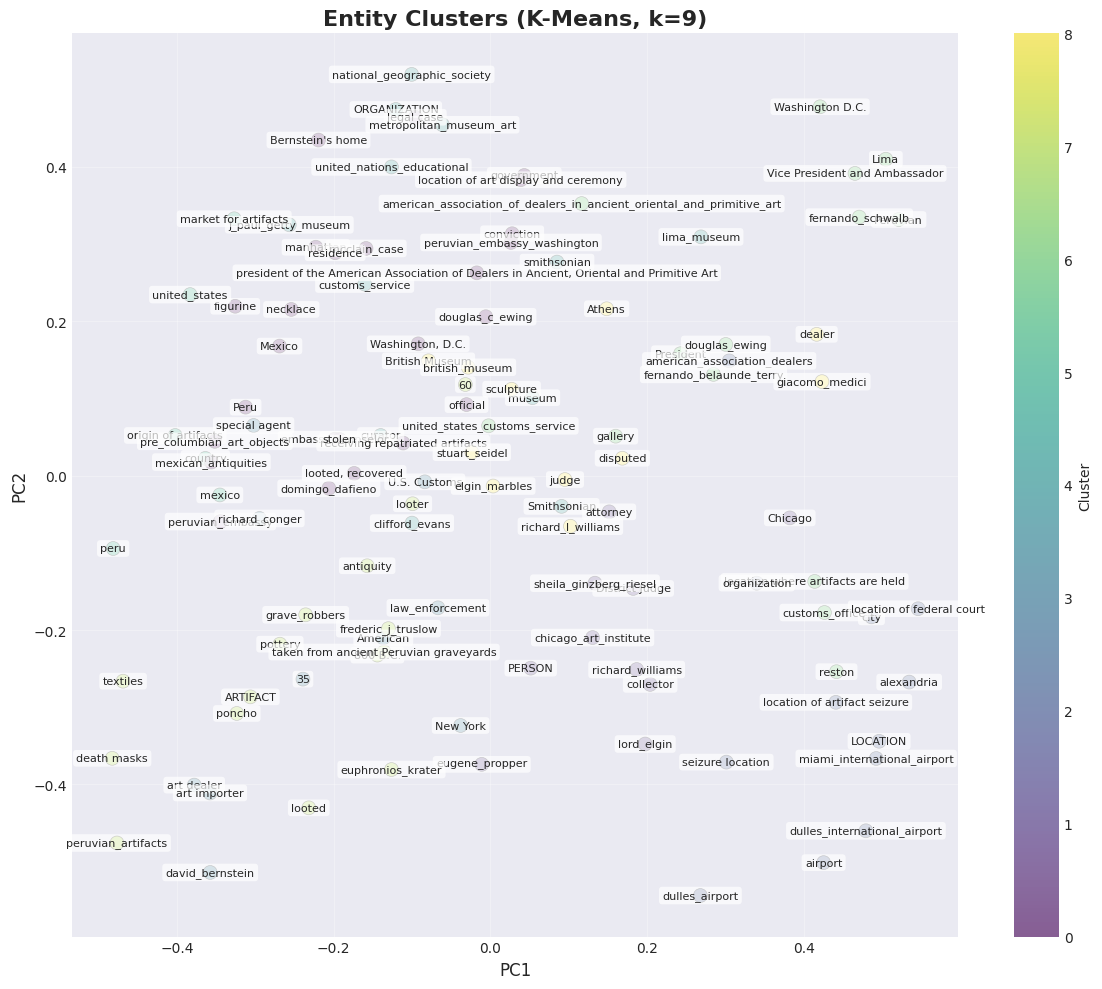


📊 Cluster Assignments:

  Cluster 0: 25 entities
    Bernstein's home, Mexico, Peru, Washington, D.C., conviction, domingo_dafieno, douglas_c_ewing, embassy counselor, figurine, government, legal case, location of art display and ceremony, looted, recovered, manhattan, mcclain_case, mexican_antiquities, necklace, official, peruvian_embassy, peruvian_embassy_washington, pre_columbian_art_objects, president of the American Association of Dealers in Ancient, Oriental and Primitive Art, receiving repatriated artifacts, residence, stolen

  Cluster 1: 10 entities
    Chicago, District Judge, PERSON, attorney, chicago_art_institute, collector, eugene_propper, lord_elgin, richard_williams, sheila_ginzberg_riesel

  Cluster 2: 12 entities
    LOCATION, airport, alexandria, american_association_dealers, city, dulles_airport, dulles_international_airport, location of artifact seizure, location of federal court, miami_international_airport, organization, seizure location

  Cluster 3: 10 entitie

In [18]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(entity_embeddings)

# Visualize clusters in PCA space
plt.figure(figsize=(12, 10))
scatter = plt.scatter(entity_pca[:, 0], entity_pca[:, 1],
                     c=cluster_labels, cmap='viridis',
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

for i, entity_id in enumerate(triples_factory.entity_id_to_label):
    plt.annotate(
        text=id_to_entity[entity_id],
        xy=(entity_pca[i, 0], entity_pca[i, 1]),
        fontsize=8,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

plt.colorbar(scatter, label='Cluster')
plt.title(f'Entity Clusters (K-Means, k={optimal_k})', fontsize=16, fontweight='bold')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('entity_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Print cluster assignments
print("\n📊 Cluster Assignments:")
for cluster_id in range(optimal_k):
    cluster_entities = [entity_labels[i] for i in range(len(entity_labels))
                       if cluster_labels[i] == cluster_id]
    print(f"\n  Cluster {cluster_id}: {len(cluster_entities)} entities")
    print(f"    {', '.join(cluster_entities)}")

In [19]:
# Hierarchical clustering dendrogram
if len(entity_embeddings) < 50:  # Only for smaller graphs
    plt.figure(figsize=(14, 8))
    linkage_matrix = linkage(entity_embeddings, method='ward')

    dendrogram(
        linkage_matrix,
        labels=entity_labels,
        leaf_font_size=10,
        leaf_rotation=90
    )

    plt.title('Hierarchical Clustering Dendrogram', fontsize=16, fontweight='bold')
    plt.xlabel('Entity', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.tight_layout()
    plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️  Dendrogram skipped (too many entities for clear visualization)")

⚠️  Dendrogram skipped (too many entities for clear visualization)


## Link Prediction and Analysis

In [47]:
example_relation = list(triples_factory.relation_to_id.keys())[12]
example_relation


'hasRole'

In [50]:
# Example: Predict missing links
print("\n🔮 Link Prediction Examples:\n")

# Predict tail entity for given head and relation
if len(entity_labels) >= 2:
    example_head = entity_labels[30]
    example_relation = list(triples_factory.relation_to_id.keys())[12]

    print(f"Query: ({example_head}, {example_relation}, ?)")

    predictions = predict.predict_target(
        model=best_model,
        head=example_head,
        relation=example_relation,
        triples_factory=triples_factory
    ).add_membership_columns(training=training, testing=testing)

    print("\nTop 10 predictions:")
    display(predictions.df.head(10))


🔮 Link Prediction Examples:

Query: (art importer, hasRole, ?)

Top 10 predictions:


,tail_id,score,tail_label,in_training,in_testing
30,30,-3.983347,art importer,False,False
29,29,-4.151199,art dealer,False,False
107,107,-7.628817,special agent,False,False
42,42,-7.793844,david_bernstein,False,False
0,0,-7.894993,35,False,False
13,13,-8.020475,New York,False,False
74,74,-8.056210,looter,False,False
86,86,-8.602003,official,False,False
39,39,-8.909296,curator,False,False
9,9,-8.910341,District Judge,False,False


In [51]:
# Score unseen triples
print("\n🎲 Scoring Hypothetical Triples:\n")

# Create some plausible unseen triples to score
# Adjust these based on your actual entities and relations
if len(entity_labels) >= 3:
    unseen_triples = np.array([
        [entity_labels[0], list(triples_factory.relation_to_id.keys())[0], entity_labels[1]],
        [entity_labels[1], list(triples_factory.relation_to_id.keys())[0], entity_labels[2]],
    ])

    unseen_factory = TriplesFactory.from_labeled_triples(triples=unseen_triples)

    predictions = predict.predict_triples(
        model=best_model,
        triples=unseen_factory
    )

    results_df = predictions.process(factory=unseen_factory).df
    print("Triple plausibility scores:")
    display(results_df)


🎲 Scoring Hypothetical Triples:

Triple plausibility scores:


,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,0,35,0,authenticatedBy,1,60,-6.071850
1,1,60,0,authenticatedBy,2,800 B.C.,-13.611824


### Relation Pattern Analysis

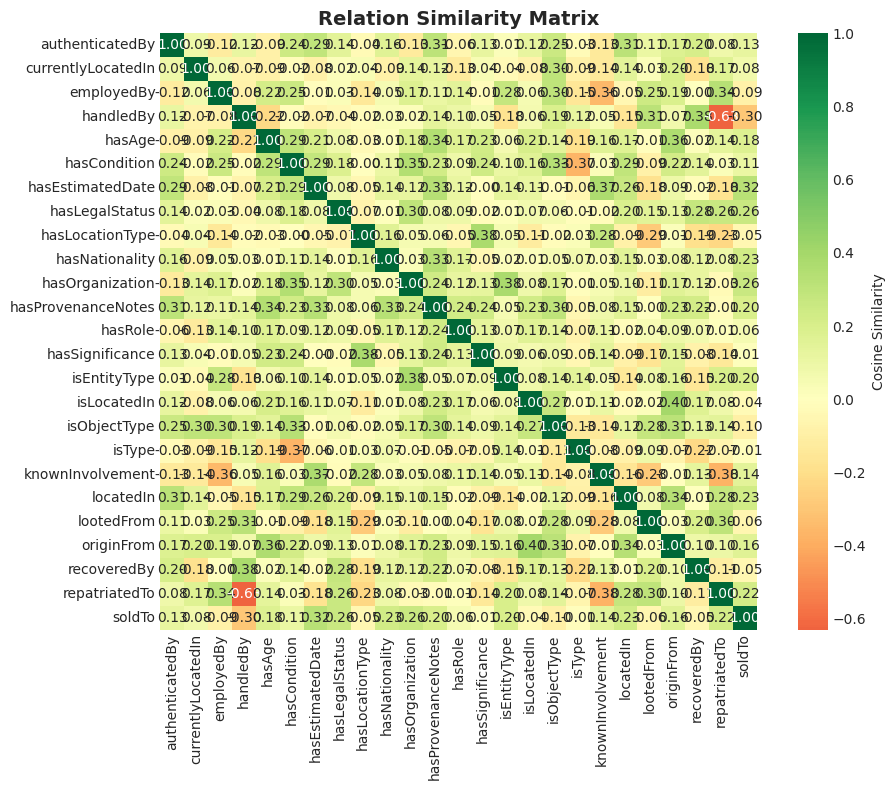


🔗 Most Similar Relation Pairs:


In [53]:
# Analyze relation embeddings
relation_labels = [id_to_relation[i] for i in range(len(id_to_relation))]

# Compute relation similarity
relation_similarity = cosine_similarity(relation_embeddings)
relation_similarity_df = pd.DataFrame(
    relation_similarity,
    index=relation_labels,
    columns=relation_labels
)

if len(relation_labels) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(relation_similarity_df, annot=True, fmt='.2f',
                cmap='RdYlGn', center=0, square=True,
                cbar_kws={'label': 'Cosine Similarity'})
    plt.title('Relation Similarity Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('relation_similarity.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n🔗 Most Similar Relation Pairs:")
    np.fill_diagonal(relation_similarity, -1)
    for i in range(len(relation_labels)):
        for j in range(i+1, len(relation_labels)):
            sim = relation_similarity[i, j]
            if sim > 0.5:  # Only show reasonably similar pairs
                print(f"  {relation_labels[i]} <-> {relation_labels[j]}: {sim:.4f}")

## Interactive Visualizations (Plotly)

In [54]:
if PLOTLY_AVAILABLE:
    # 3D PCA visualization
    pca_3d = PCA(n_components=3, random_state=42)
    entity_pca_3d = pca_3d.fit_transform(entity_embeddings)

    fig = go.Figure(data=[go.Scatter3d(
        x=entity_pca_3d[:, 0],
        y=entity_pca_3d[:, 1],
        z=entity_pca_3d[:, 2],
        mode='markers+text',
        marker=dict(
            size=10,
            color=cluster_labels if len(cluster_labels) == len(entity_labels) else None,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Cluster"),
            line=dict(color='black', width=0.5)
        ),
        text=entity_labels,
        textposition='top center',
        textfont=dict(size=10),
    )])

    fig.update_layout(
        title=f'Interactive 3D Entity Embeddings ({best_model_name})',
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        ),
        width=1000,
        height=800
    )

    fig.write_html('interactive_embeddings_3d.html')
    print("\n✅ Saved interactive 3D visualization to 'interactive_embeddings_3d.html'")
    fig.show()
else:
    print("⚠️  Plotly not available for interactive visualizations")


✅ Saved interactive 3D visualization to 'interactive_embeddings_3d.html'


## Save Results and Embeddings

In [56]:
# Save embeddings
output_dir = Path('embedding_output')
output_dir.mkdir(exist_ok=True)

# Save entity embeddings
entity_embedding_df = pd.DataFrame(
    entity_embeddings,
    index=entity_labels
)
entity_embedding_df.to_csv(output_dir / 'entity_embeddings.csv')

# Save relation embeddings
relation_embedding_df = pd.DataFrame(
    relation_embeddings,
    index=relation_labels
)
relation_embedding_df.to_csv(output_dir / 'relation_embeddings.csv')

# Save similarity matrix
similarity_df.to_csv(output_dir / 'entity_similarity.csv')

# Save cluster assignments
cluster_df = pd.DataFrame({
    'entity': entity_labels,
    'cluster': cluster_labels
})
cluster_df.to_csv(output_dir / 'entity_clusters.csv', index=False)

# Save metrics
metrics_df.to_csv(output_dir / 'model_metrics.csv')

# Save best model
results[best_model_name].save_to_directory(str(output_dir / 'best_model'))

print(f"\n✅ All results saved to '{output_dir}' directory")
print(f"\nSaved files:")
for file in output_dir.glob('*'):
    print(f"  - {file.name}")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=115, num_relations=25, create_inverse_triples=False, num_triples=114) to file:///content/embedding_output/best_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/embedding_output/best_model



✅ All results saved to 'embedding_output' directory

Saved files:
  - best_model
  - entity_embeddings.csv
  - entity_clusters.csv
  - entity_similarity.csv
  - model_metrics.csv
  - relation_embeddings.csv


## Summary and Insights

### Key Findings:

In [57]:
print("\n" + "="*70)
print("KNOWLEDGE GRAPH EMBEDDING ANALYSIS SUMMARY")
print("="*70)

print(f"\n📊 Dataset Statistics:")
print(f"  Total triples: {len(df)}")
print(f"  Unique entities: {len(entity_labels)}")
print(f"  Unique relations: {len(relation_labels)}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"  MRR: {metrics_df.loc[best_model_name, 'MRR']:.4f}")
print(f"  Hits@1: {metrics_df.loc[best_model_name, 'Hits@1']:.4f}")
print(f"  Hits@10: {metrics_df.loc[best_model_name, 'Hits@10']:.4f}")

print(f"\n🎯 Hardware Utilization:")
print(f"  Device: {device}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Batch size: {BATCH_SIZE}")

print(f"\n🔍 Embedding Insights:")
print(f"  Optimal clusters: {optimal_k}")
print(f"  PCA variance explained: {pca.explained_variance_ratio_.sum():.1%}")

print(f"\n📁 Output Location: {output_dir.absolute()}")

print("\n" + "="*70)


KNOWLEDGE GRAPH EMBEDDING ANALYSIS SUMMARY

📊 Dataset Statistics:
  Total triples: 171
  Unique entities: 115
  Unique relations: 25

🏆 Best Model: TransE
  MRR: 0.0988
  Hits@1: 0.0000
  Hits@10: 0.3800

🎯 Hardware Utilization:
  Device: cuda
  Embedding dimension: 64
  Batch size: 256

🔍 Embedding Insights:
  Optimal clusters: 9
  PCA variance explained: 15.8%

📁 Output Location: /content/embedding_output

